In [1]:
from scripts.pipeline_tools import (
    prepare_data,
    regressor_uncertainty,
    select_unstable_data,
    retrain_regressor,
    uncertainty_change,
    mse_change, 
    get_mse, 
    plot_mse_change
)
from scripts.Models import ITGDatasetDF, load_model, ITGDataset
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from scripts.utils import train_keys
import copy
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
pretrained = {
    "ITG_class": {
        "trained": True,
        # "save_path": "/home/tmadula/UKAEAGroupProject/src/notebooks/classifier_model.pt",
        # "save_path": "/unix/atlastracking/jbarr/UKAEAGroupProject/src/notebooks/classifier_model.pt",
        "save_path": "/Users/thandikiremadula/Desktop/UKAEA_data/classifier_model.pt"
    },
    "ITG_reg": {
        "trained": True,
        # "save_path": "/home/tmadula/UKAEAGroupProject/src/notebooks/regression_model.pt",
        # "save_path": "/unix/atlastracking/jbarr/UKAEAGroupProject/src/notebooks/regression_model.pt",
        "save_path": "/Users/thandikiremadula/Desktop/UKAEA_data/regression_model.pt"
    },
}

# Data loading

# TRAIN_PATH = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
# TRAIN_PATH = "/unix/atlastracking/jbarr/train_data_clipped.pkl"
TRAIN_PATH = "/Users/thandikiremadula/Desktop/UKAEA_data/train_data_clipped.pkl"

# VALIDATION_PATH = "/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl"
# VALIDATION_PATH = "/unix/atlastracking/jbarr/valid_data_clipped.pkl"
VALIDATION_PATH = "/Users/thandikiremadula/Desktop/UKAEA_data/valid_data_clipped.pkl"

In [3]:
train_data, val_data = prepare_data(
    TRAIN_PATH, VALIDATION_PATH, target_column="efiitg_gb", target_var="itg"
)

scaler = StandardScaler()
scaler.fit_transform(train_data.drop(["itg"], axis=1))

train_dataset = ITGDatasetDF(train_data, target_column="efiitg_gb", target_var="itg")
valid_dataset = ITGDatasetDF(val_data, target_column="efiitg_gb", target_var="itg")

# # TODO: further testing of the scale function
train_dataset.scale(scaler)
valid_dataset.scale(scaler)

In [4]:
# Load pretrained models
print("Loaded the following models:\n")
models = {}
for model in pretrained:
    if pretrained[model]["trained"] == True:
        trained_model = load_model(model, pretrained[model]["save_path"])
        models[model] = trained_model

Loaded the following models:

Model Loaded: ITG_class
Model Loaded: ITG_reg


In [5]:
# TODO: Needs to be the true training samples used!!!
train_sample = train_dataset.sample(10_000)
valid_sample = valid_dataset.sample(10_000)

# remove the sampled data points from the dataset
valid_dataset.remove(valid_sample.data.index)

In [6]:
select_unstable_data(valid_sample, batch_size=100, classifier=models["ITG_class"])


Running classifier selection...



100%|██████████| 100/100 [00:03<00:00, 26.34it/s]


Stable points: 7480
Misclassified points: 644
Percentage of misclassified points:  6.44%

Dropped 7718 rows


In [7]:
uncertain_datset, uncert_before, data_idx = regressor_uncertainty(
    valid_sample, models["ITG_reg"], n_runs=15, keep=0.25
)
train_sample_origin, train_uncert_before, train_uncert_idx = regressor_uncertainty(
    train_sample, models["ITG_reg"], n_runs=15,train_data=True
    )

train_sample.add(uncertain_datset)

uncertain_loader = DataLoader(train_sample, batch_size=len(train_sample), shuffle=True)


Running MC Dropout....



100%|██████████| 15/15 [00:20<00:00,  1.34s/it]



Number of points passed for MC dropout: 2282

Running MC Dropout....



100%|██████████| 15/15 [01:34<00:00,  6.30s/it]



Number of points passed for MC dropout: 10000


In [8]:
prediction_before, prediction_idx_order = models["ITG_reg"].predict(uncertain_loader)

In [9]:
# Switching validation dataset to numpy arrays to see if it is quicker
x_array = valid_dataset.data[train_keys].values
y_array = valid_dataset.data["itg"].values
z_array = valid_dataset.data["efiitg_gb"].values
dataset_numpy = ITGDataset(x_array, y_array, z_array)
valid_loader = DataLoader(
    dataset_numpy, batch_size=int(0.1 * len(y_array)), shuffle=True
)

In [10]:
# Retrain Regressor (Further research required)
retrain_regressor(
    uncertain_loader,
    valid_loader,
    models["ITG_reg"],
    learning_rate=1e-3,
    epochs=50,
    validation_step=True,
    mode="warm_start",
)


Retraining regressor...

Training on 10570 points


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Initial loss: 0.6609
Train Step:  0
Loss: 1.0575
Validation Step:  0


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


Test loss: 0.5772
Train Step:  1
Loss: 0.8948
Train Step:  2
Loss: 0.7860
Train Step:  3
Loss: 0.7143
Train Step:  4
Loss: 0.6829
Train Step:  5
Loss: 0.6518
Train Step:  6
Loss: 0.6260
Train Step:  7
Loss: 0.5789
Train Step:  8
Loss: 0.5374
Train Step:  9
Loss: 0.5044
Train Step:  10
Loss: 0.4785
Validation Step:  10


100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


Test loss: 0.3444
Train Step:  11
Loss: 0.4655
Train Step:  12
Loss: 0.4601
Train Step:  13
Loss: 0.4427
Train Step:  14
Loss: 0.4239
Train Step:  15
Loss: 0.4010
Train Step:  16
Loss: 0.3771
Train Step:  17
Loss: 0.3645
Train Step:  18
Loss: 0.3519
Train Step:  19
Loss: 0.3530
Train Step:  20
Loss: 0.3325
Validation Step:  20


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


Test loss: 0.2609
Train Step:  21
Loss: 0.3082
Train Step:  22
Loss: 0.3158
Train Step:  23
Loss: 0.3155
Train Step:  24
Loss: 0.3072
Train Step:  25
Loss: 0.3021
Train Step:  26
Loss: 0.2938
Train Step:  27
Loss: 0.2892
Train Step:  28
Loss: 0.2782
Train Step:  29
Loss: 0.2741
Train Step:  30
Loss: 0.2743
Validation Step:  30


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


Test loss: 0.2299
Train Step:  31
Loss: 0.2729
Train Step:  32
Loss: 0.2625
Train Step:  33
Loss: 0.2677
Train Step:  34
Loss: 0.2582
Train Step:  35
Loss: 0.2489
Train Step:  36
Loss: 0.2521
Train Step:  37
Loss: 0.2471
Train Step:  38
Loss: 0.2473
Train Step:  39
Loss: 0.2454
Train Step:  40
Loss: 0.2448
Validation Step:  40


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Test loss: 0.2151
Train Step:  41
Loss: 0.2361
Train Step:  42
Loss: 0.2330
Train Step:  43
Loss: 0.2291
Train Step:  44
Loss: 0.2281
Train Step:  45
Loss: 0.2246
Train Step:  46
Loss: 0.2231
Train Step:  47
Loss: 0.2252
Train Step:  48
Loss: 0.2276
Train Step:  49
Loss: 0.2210


In [11]:
prediction_after,_ = models["ITG_reg"].predict(uncertain_loader, prediction_idx_order)

In [12]:
_, uncert_after,_ = regressor_uncertainty(valid_sample, models["ITG_reg"], n_runs=15, keep=0.25, order_idx=data_idx)
_, train_uncert_after,_ = regressor_uncertainty(train_sample_origin, models["ITG_reg"], n_runs=15,order_idx=train_uncert_idx, train_data=True)


Running MC Dropout....



100%|██████████| 15/15 [00:18<00:00,  1.23s/it]



Number of points passed for MC dropout: 2282

Running MC Dropout....



100%|██████████| 15/15 [01:24<00:00,  5.66s/it]



Number of points passed for MC dropout: 10000


 Decreased 84.386% Increased: 15.614 % No Change: 0.000 
Initial Average Uncertainty: 0.5197, Final Average Uncertainty: 0.3929


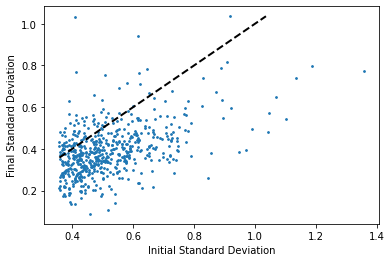

In [13]:
uncertainty_change(x=uncert_before, y=uncert_after);

 Decreased 72.660% Increased: 27.340 % No Change: 0.000 
Initial Average Uncertainty: 0.1068, Final Average Uncertainty: 0.0924


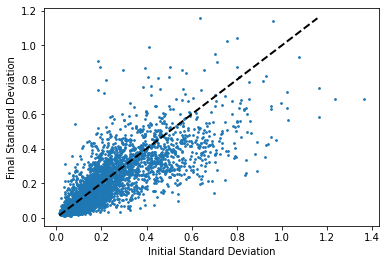

In [14]:
uncertainty_change(x=train_uncert_before, y=train_uncert_after);


Change in MSE for novel dataset: -0.0726



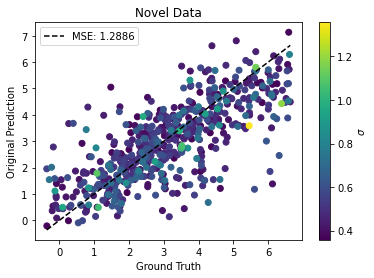

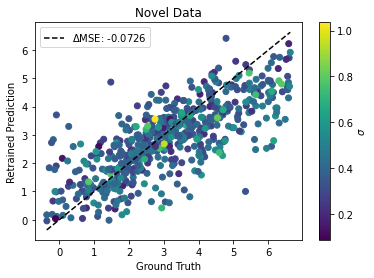

In [15]:
mse_change(prediction_before, prediction_after,prediction_idx_order,data_idx, uncertain_loader,[uncert_before, uncert_after])


Change in MSE for train dataset: -0.0046



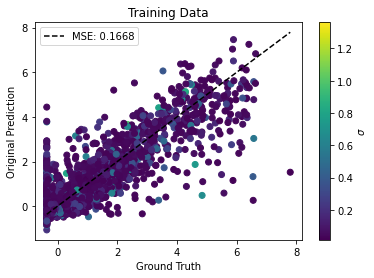

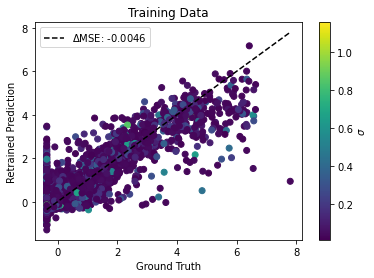

In [16]:
mse_change(
    prediction_before,
    prediction_after,
    prediction_idx_order,
    train_uncert_idx,
    uncertain_loader,
    uncertainties=[train_uncert_before, train_uncert_after],
    data="train"
     )

In [17]:
idxs = prediction_idx_order.astype(int)
ground_truth = uncertain_loader.dataset.data.loc[idxs]
ground_truth = ground_truth['efiitg_gb']
ground_truth = ground_truth.to_numpy()

In [18]:
mse_before = get_mse(prediction_before, ground_truth)
mse_after = get_mse(prediction_after, ground_truth)
delta_mse = mse_after - mse_before

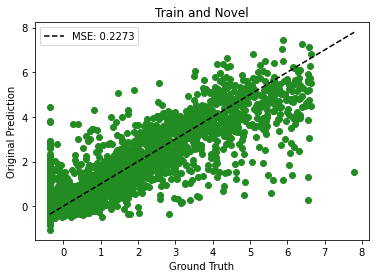

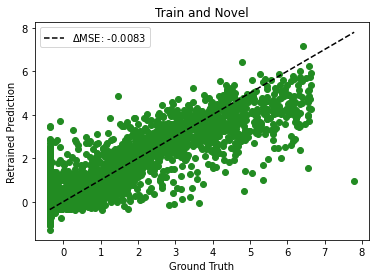

In [19]:
plot_mse_change(ground_truth, prediction_before, prediction_after, uncertainties=None,data="Train and Novel")